In [2]:
!pip install --upgrade pandas

In [4]:
%%capture
%pip install s3fs==0.5.0
%pip install real-simple-seismic
!pip uninstall -y fsspec boto3 s3fs
!pip install boto3 real-simple-seismic fsspec

In [10]:
from math import floor, ceil
from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json
import pandas as pd
import numpy as np

In [6]:
well_file = 'poseidon_geoml_training_wells.json.gz'
test_well_file = 'poseidon_geoml_testing_wells_blank.json.gz'

In [7]:
#
def get_well_seismic(well_file):
#     %%time
    well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
    

    well_df = read_json(
        path_or_buf=well_bucket + well_file,
        compression='gzip',
    )

    well_df.set_index(['well_id', 'twt'], inplace=True)

    '''
    Get well names and separate `DataFrame` per well, and put in a dictionary.
    We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
    query from the seismic data.
    '''
    well_names = well_df.index.levels[0].to_list()
    num_wells = len(well_names)

    wells = {}
    il_ranges = {}
    xl_ranges = {}
    for well_name in well_names:
        well = well_df.loc[well_name]
        well_ils_xls = well[['inline', 'xline']]
        il_xl_min = well_ils_xls.min()
        il_xl_max = well_ils_xls.max()

        wells[well_name] = well
        il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
        xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])

    '''
    Now, we need to extract seismic values around the wellbore. Let's start with
    mounting `real-simple-seismic` volumes of interest so we can query later.
    **Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**
    **Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**
    '''
    seismic_bucket = r's3://sagemaker-gitc2021/poseidon/seismic/rss/'

    seismic_files = [
        'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
        'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
        'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
        'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
    ]

    '''
    We loop through all files, and make connections to all four.
    This takes about a minute.
    The handles are later used for querying.
    '''
    rss_handles = []
    for seismic_file in seismic_files:
        current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

        rss_handles.append(current_rss)

    from itertools import product
    import numpy as np

    # let's have nicer names for seismic data
    seismic_names = ('near', 'mid', 'far', 'velocity')

    well_seismic = {}
    for well in wells.keys():
        il_min, il_max = il_ranges[well]
        xl_min, xl_max = xl_ranges[well]

        ils = range(il_min, il_max + 1, 1)  # inline increment is 1
        xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

        # Use product to have all il/xl pairs within our ranges
        ilxl_pairs = list(product(ils, xls))

        cube_data = {}
        # In rss, for minicube extraction we query trace by trace.
        for rss_handle, seismic_name in zip(rss_handles, seismic_names):
            tmp = []
            for trace_ilxl in ilxl_pairs:
                tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

            # Traces aren't in a "cube" shape, they come sequential. So we reshape!
            cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

        well_seismic[well] = cube_data
    return well_seismic

In [8]:
well_seismic = get_well_seismic(well_file)
test_well_seismic = get_well_seismic(test_well_file)

Connection complete.


In [11]:
horizon_bucket = 's3://sagemaker-gitc2021/poseidon/horizons/'
horizon_files = ['water_bottom', 'top_heywood', 'top_johnson', 'top_jameison', 'top_near_plover']

horizons = []
for horizon in horizon_files:
    horizons.append(
        read_csv(filepath_or_buffer=horizon_bucket + f'{horizon}.csv.gz',
                 index_col=[0, 1],
                 compression='gzip'))

horizons = concat(horizons, axis=1)

In [96]:
horizons

water_bottom  top_heywood  top_johnson  top_jameison  \
inline xline                                                         
1080   1080          581.9       2058.3       2346.8        2719.2   
       1081          581.8       2058.3       2346.8        2719.3   
       1082          581.8       2058.4       2347.1        2719.5   
       1083          581.8       2058.4       2347.3        2719.7   
       1084          581.8       2058.4       2347.6        2720.0   
...                    ...          ...          ...           ...   
3700   3196          648.1       2062.7       2493.0        2633.7   
       3197          648.2       2062.7       2493.0        2633.7   
       3198          648.2       2062.7       2492.9        2633.6   
       3199          648.2       2062.7       2492.9        2633.6   
       3200          648.2       2062.7       2492.9        2633.6   

              top_near_plover  
inline xline                   
1080   1080            3327.9  
       1081            3327.8  
       1082            3327.8  
       1083            3327.8  
       1084            3327.7  
...                       ...  
3700   3196            3985.7  
       3197            3985.1  
       3198            3984.5  
       3199            3983.9  
       3200            3983.3  

[5559141 rows x 5 columns]

In [115]:
horizons.loc[1080,1081]

water_bottom        581.8
top_heywood        2058.3
top_johnson        2346.8
top_jameison       2719.3
top_near_plover    3327.8
Name: (1080, 1081), dtype: float64

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

In [255]:
# well_seismic.keys()
# test_well_seismic.keys()

In [42]:
def get_near_comp_data(well_seismic):
    near_comp_data = {}
    for well in well_seismic.keys():
        near_comp_data[well] = well_seismic[well]['near']
    return near_comp_data

In [43]:
near_comp_data = get_near_comp_data(well_seismic)
test_near_comp_data = get_near_comp_data(test_well_seismic)

In [26]:
def get_mid_comp_data(well_seismic):
    mid_comp_data = {}
    for well in well_seismic.keys():
        mid_comp_data[well] = well_seismic[well]['mid']
    return mid_comp_data

def get_far_comp_data(well_seismic):
    far_comp_data = {}
    for well in well_seismic.keys():
        far_comp_data[well] = well_seismic[well]['far']
    return far_comp_data

In [27]:
mid_comp_data = get_mid_comp_data(well_seismic)
test_mid_comp_data = get_mid_comp_data(test_well_seismic)
far_comp_data = get_far_comp_data(well_seismic)
test_far_comp_data = get_far_comp_data(test_well_seismic)

In [256]:
def get_vel_comp_data(well_seismic):
    vel_comp_data = {}
    for well in well_seismic.keys():
        vel_comp_data[well] = well_seismic[well]['velocity']
    return vel_comp_data

In [258]:
vel_comp_data = get_vel_comp_data(well_seismic)
test_vel_comp_data = get_vel_comp_data(test_well_seismic)

In [28]:
def get_near_comp_data_temp(near_comp_data):
    near_comp_data_temp = {}
    for well in near_comp_data.keys():
        near_comp_data_temp[well] = pd.DataFrame(np.mean((np.mean(near_comp_data[well],axis=1)), axis=0), columns=[well])
    return near_comp_data_temp

In [29]:
near_comp_data_temp = get_near_comp_data_temp(near_comp_data)
test_near_comp_data_temp = get_near_comp_data_temp(test_near_comp_data)

In [30]:
mid_comp_data_temp = get_near_comp_data_temp(mid_comp_data)
test_mid_comp_data_temp = get_near_comp_data_temp(test_mid_comp_data)
far_comp_data_temp = get_near_comp_data_temp(far_comp_data)
test_far_comp_data_temp = get_near_comp_data_temp(test_far_comp_data)

In [263]:
vel_comp_data_temp = get_near_comp_data_temp(vel_comp_data)
test_vel_comp_data_temp = get_near_comp_data_temp(test_vel_comp_data)

In [32]:
def visual_near_comp_data_temp(near_comp_data_temp):
    for composite in near_comp_data_temp.keys():
        plt.figure(figsize=(20,1))
        plt.plot(near_comp_data_temp[composite])
        plt.title('composite trace')
        plt.ylim(-100000,100000)
        plt.xlabel('twt (ms) ')
        plt.ylabel('amplitude')
    return

In [37]:
# visual_near_comp_data_temp(near_comp_data_temp)
# visual_near_comp_data_temp(test_far_comp_data_temp)

In [38]:
def get_data_concat_resamp_interp(near_comp_data_temp):
    # index at 4ms 
    seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])
    # index at .5 ms 
    resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])
    data_concat_temp = [seismic_twt]
    for composite in near_comp_data_temp.keys():
        data_concat_temp.append(near_comp_data_temp[composite])
    tt_seismic_temp = pd.concat(data_concat_temp, axis=1)
    data_concat_resamp_raw_temp = resamp_twt.merge(tt_seismic_temp, how='left', on=['twt'])
    data_concat_resamp_interp = data_concat_resamp_raw_temp.interpolate(method='cubic', limit_direction='forward', axis=0)  
    return data_concat_resamp_interp

In [44]:
data_concat_resamp_interp = get_data_concat_resamp_interp(near_comp_data_temp)
test_data_concat_resamp_interp = get_data_concat_resamp_interp(test_near_comp_data_temp)

In [45]:
data_mid_concat_resamp_interp = get_data_concat_resamp_interp(mid_comp_data_temp)
test_data_mid_concat_resamp_interp = get_data_concat_resamp_interp(test_mid_comp_data_temp)
data_far_concat_resamp_interp = get_data_concat_resamp_interp(far_comp_data_temp)
test_data_far_concat_resamp_interp = get_data_concat_resamp_interp(test_far_comp_data_temp)

In [261]:
def get_vel_data_concat_resamp_interp(near_comp_data_temp):
    # index at 4ms 
    seismic_twt = pd.DataFrame(np.arange(0, 6010.0, 10.0), columns=['twt'])
    # index at .5 ms 
    resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])
    data_concat_temp = [seismic_twt]
    for composite in near_comp_data_temp.keys():
        data_concat_temp.append(near_comp_data_temp[composite])
    tt_seismic_temp = pd.concat(data_concat_temp, axis=1)
    data_concat_resamp_raw_temp = resamp_twt.merge(tt_seismic_temp, how='left', on=['twt'])
    data_concat_resamp_interp = data_concat_resamp_raw_temp.interpolate(method='cubic', limit_direction='forward', axis=0)  
    return data_concat_resamp_interp

In [265]:
vel_data_resamp = get_vel_data_concat_resamp_interp(vel_comp_data_temp)
test_data_resamp = get_vel_data_concat_resamp_interp(test_vel_comp_data_temp)

In [46]:
def get_near_composite_resamp_temp(data_concat_resamp_interp):
    near_composite_resamp_temp = {}
    for ind, well in enumerate(data_concat_resamp_interp.keys()):
        if ind==0: continue
        near_composite_resamp_temp[well] = data_concat_resamp_interp[['twt', well]].copy()
    return near_composite_resamp_temp

In [47]:
near_composite_resamp_temp = get_near_composite_resamp_temp(data_concat_resamp_interp)
test_near_composite_resamp_temp = get_near_composite_resamp_temp(test_data_concat_resamp_interp)

In [48]:
mid_composite_resamp_temp = get_near_composite_resamp_temp(data_mid_concat_resamp_interp)
test_mid_composite_resamp_temp = get_near_composite_resamp_temp(test_data_mid_concat_resamp_interp)
far_composite_resamp_temp = get_near_composite_resamp_temp(data_far_concat_resamp_interp)
test_far_composite_resamp_temp = get_near_composite_resamp_temp(test_data_far_concat_resamp_interp)

In [274]:
vel_composite_resamp_temp = get_near_composite_resamp_temp(vel_data_resamp)
test_vel_composite_resamp_temp = get_near_composite_resamp_temp(test_data_resamp)

In [272]:
# vel_composite_resamp_temp['well_01']

In [50]:
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
training_well_file = 'poseidon_geoml_training_wells.json.gz'
test_well_file = 'poseidon_geoml_testing_wells_blank.json.gz'
def get_well_df(well_file):
    well_df = read_json(
        path_or_buf=well_bucket + well_file,
        compression='gzip',
    )

    well_df.set_index(['well_id', 'twt'], inplace=True)
    return well_df

In [51]:
well_df = get_well_df(training_well_file)
test_well_df = get_well_df(test_well_file)

In [52]:
def get_well_df_temp(well_df,near_comp_data):
    well_df_temp = {}
    for well in near_comp_data.keys():
        well_df_temp[well] = well_df.loc[well].reset_index()
    return well_df_temp

In [53]:
well_df_temp = get_well_df_temp(well_df,near_comp_data)
test_well_df_temp = get_well_df_temp(test_well_df,test_near_comp_data)

In [285]:
# test_well_df_temp['well_07']

In [56]:
for well in well_df_temp.keys():
    well_df_temp[well]['Zp'] = (1000000/well_df_temp[well]['dtc'])*well_df_temp[well]['rhob']
    well_df_temp[well]['Zs'] = (1000000/well_df_temp[well]['dts'])*well_df_temp[well]['rhob']
# only well_df_temp need to run this. test_well_df_temp does not have dtc and rhob info

In [57]:
def get_well_stripped_temp(well_df_temp):
    well_stripped_temp = {} 
    for well in well_df_temp.keys():
        well_stripped_temp[well] = well_df_temp[well][['twt','inline','xline','Zp','Zs','rhob']].copy()
    return well_stripped_temp

In [288]:
well_stripped_temp = get_well_stripped_temp(well_df_temp)

In [293]:
# well_stripped_temp['well_01']
test_well_stripped_temp = test_well_df_temp

In [59]:
def get_well_tt_temp(well_df_temp, near_composite_resamp_temp, well_stripped_temp):
    well_tt_temp = {}
    for well in well_df_temp.keys():
        well_tt_temp[well] = near_composite_resamp_temp[well].merge(well_stripped_temp[well], how='left', on=['twt'])
        well_tt_temp[well]['well_name'] = [well] * len(well_tt_temp[well])
        well_tt_temp[well].set_index(['well_name'], inplace=True)
        well_tt_temp[well].rename(columns={well: "composite_trace"}, inplace=True)
    return well_tt_temp

In [60]:
well_tt_temp = get_well_tt_temp(well_df_temp, near_composite_resamp_temp, well_stripped_temp)
test_well_tt_temp = get_well_tt_temp(test_well_df_temp, test_near_composite_resamp_temp, test_well_df_temp)

In [295]:
mid_well_tt_temp = get_well_tt_temp(well_df_temp, mid_composite_resamp_temp, well_stripped_temp)
far_well_tt_temp = get_well_tt_temp(well_df_temp, far_composite_resamp_temp, well_stripped_temp)
test_mid_well_tt_temp = get_well_tt_temp(test_well_df_temp, test_mid_composite_resamp_temp, test_well_stripped_temp)
test_far_well_tt_temp = get_well_tt_temp(test_well_df_temp, test_far_composite_resamp_temp, test_well_stripped_temp)

In [297]:
vel_well_tt_temp = get_well_tt_temp(well_df_temp, vel_composite_resamp_temp, well_stripped_temp)
test_vel_well_tt_temp = get_well_tt_temp(test_well_df_temp, test_vel_composite_resamp_temp, test_well_stripped_temp)

In [307]:
well_tt_temp['well_01']

,twt,composite_trace,inline,xline,Zp,Zs,rhob,GradTrail5,GradLead5,GradTrail10,GradLead10,HTEnv,mid_trace,far_trace,vel_trace
well_name,,,,,,,,,,,,,,,
well_01,0.0,-2.459141,NaN,NaN,NaN,NaN,NaN,8.881784e-16,NaN,1.332268e-15,NaN,5.213059,-2.177104,-1.195044,1523.470219
well_01,0.5,-2.459141,NaN,NaN,NaN,NaN,NaN,4.440892e-16,NaN,0.000000e+00,NaN,5.210687,-2.177104,-1.195044,1523.470526
well_01,1.0,-2.459141,NaN,NaN,NaN,NaN,NaN,1.332268e-15,NaN,4.440892e-16,NaN,5.208318,-2.177104,-1.195044,1523.470786
well_01,1.5,-2.459141,NaN,NaN,NaN,NaN,NaN,-4.440892e-16,NaN,0.000000e+00,NaN,5.205953,-2.177104,-1.195044,1523.471001
well_01,2.0,-2.459141,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,5.203590,-2.177104,-1.195044,1523.471174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_01,5998.0,-2.459141,NaN,NaN,NaN,NaN,NaN,NaN,4.440892e-16,NaN,-4.440892e-16,5.224962,-2.177104,-1.195044,5227.339589
well_01,5998.5,-2.459141,NaN,NaN,NaN,NaN,NaN,NaN,-4.440892e-16,NaN,-4.440892e-16,5.222575,-2.177104,-1.195044,5227.341835
well_01,5999.0,-2.459141,NaN,NaN,NaN,NaN,NaN,NaN,4.440892e-16,NaN,-4.440892e-16,5.220192,-2.177104,-1.195044,5227.344453


In [65]:
def visual_well_tt_temp(well_tt_temp):
    for tt_wells in well_tt_temp.keys():
        plt.figure(figsize=(20,3))
        plt.plot(np.arange(0,6000.5,.5), well_tt_temp[tt_wells][:])
        plt.title('Seismic and Rock Properties')
        plt.ylim(-100000,100000)
        plt.xlim(2400,3500)
        plt.xlabel('twt (ms) ')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper left', labels =['twt','Zp','Zs','rhob','composite_trace'])
    return

In [68]:
# visual_well_tt_temp(test_well_tt_temp)

let's make near mid far together into one df.


In [302]:
mid_well_tt_temp['well_01']

,twt,composite_trace,inline,xline,Zp,Zs,rhob
well_name,,,,,,,
well_01,0.0,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,0.5,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,1.0,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,1.5,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,2.0,-2.177104,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
well_01,5998.0,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,5998.5,-2.177104,NaN,NaN,NaN,NaN,NaN
well_01,5999.0,-2.177104,NaN,NaN,NaN,NaN,NaN


In [303]:
for well in well_tt_temp.keys():
    well_tt_temp[well]['mid_trace'] = mid_well_tt_temp[well]['composite_trace'].values
    well_tt_temp[well]['far_trace'] = far_well_tt_temp[well]['composite_trace'].values
    well_tt_temp[well]['vel_trace'] = vel_well_tt_temp[well]['composite_trace'].values

In [305]:
for well in test_well_tt_temp.keys():
    test_well_tt_temp[well]['mid_trace'] = test_mid_well_tt_temp[well]['composite_trace'].values
    test_well_tt_temp[well]['far_trace'] = test_far_well_tt_temp[well]['composite_trace'].values
    test_well_tt_temp[well]['vel_trace'] = test_vel_well_tt_temp[well]['composite_trace'].values

In [409]:
def update_well_tt_temp(well_tt_temp):
    for tt_well in well_tt_temp.keys():
        well_tt_temp[tt_well]['GradTrail5'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=-5)
        well_tt_temp[tt_well]['GradLead5'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=5)
        well_tt_temp[tt_well]['GradTrail10'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=-10)
        well_tt_temp[tt_well]['GradLead10'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=10)
        well_tt_temp[tt_well]['midGradTrail5'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=-5)
        well_tt_temp[tt_well]['midGradLead5'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=5)
        well_tt_temp[tt_well]['midGradTrail10'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=-10)
        well_tt_temp[tt_well]['midGradLead10'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=10)
        well_tt_temp[tt_well]['farGradTrail5'] = well_tt_temp[tt_well]['far_trace'].diff(periods=-5)
        well_tt_temp[tt_well]['farGradLead5'] = well_tt_temp[tt_well]['far_trace'].diff(periods=5)
        well_tt_temp[tt_well]['farGradTrail10'] = well_tt_temp[tt_well]['far_trace'].diff(periods=-10)
        well_tt_temp[tt_well]['farGradLead10'] = well_tt_temp[tt_well]['far_trace'].diff(periods=10)
        well_tt_temp[tt_well]['velGradTrail5'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=-5)
        well_tt_temp[tt_well]['velGradLead5'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=5)
        well_tt_temp[tt_well]['velGradTrail10'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=-10)
        well_tt_temp[tt_well]['velGradLead10'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=10)
        well_tt_temp[tt_well]['HTEnv'] = np.abs(hilbert(well_tt_temp[tt_well]['composite_trace']))
        well_tt_temp[tt_well]['GradTrail2'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=-2)
        well_tt_temp[tt_well]['GradLead2'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=2)
        well_tt_temp[tt_well]['GradTrail1'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=-1)
        well_tt_temp[tt_well]['GradLead1'] = well_tt_temp[tt_well]['composite_trace'].diff(periods=1)
        well_tt_temp[tt_well]['midGradTrail2'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=-2)
        well_tt_temp[tt_well]['midGradLead2'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=2)
        well_tt_temp[tt_well]['midGradTrail1'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=-1)
        well_tt_temp[tt_well]['midGradLead1'] = well_tt_temp[tt_well]['mid_trace'].diff(periods=1)
        well_tt_temp[tt_well]['farGradTrail2'] = well_tt_temp[tt_well]['far_trace'].diff(periods=-2)
        well_tt_temp[tt_well]['farGradLead2'] = well_tt_temp[tt_well]['far_trace'].diff(periods=2)
        well_tt_temp[tt_well]['farGradTrail1'] = well_tt_temp[tt_well]['far_trace'].diff(periods=-1)
        well_tt_temp[tt_well]['farGradLead1'] = well_tt_temp[tt_well]['far_trace'].diff(periods=1)
        well_tt_temp[tt_well]['velGradTrail2'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=-2)
        well_tt_temp[tt_well]['velGradLead2'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=2)
        well_tt_temp[tt_well]['velGradTrail1'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=-1)
        well_tt_temp[tt_well]['velGradLead1'] = well_tt_temp[tt_well]['vel_trace'].diff(periods=1)
        
    return well_tt_temp

In [410]:
well_tt_temp = update_well_tt_temp(well_tt_temp)
test_well_tt_temp = update_well_tt_temp(test_well_tt_temp)

In [318]:
# well_tt_temp['well_01']

In [411]:
total_well_num = len(well_tt_temp.keys())
training_wells_temp = []
testing_well_temp = []
test_testing_well_temp = []
for ind, well in enumerate(well_tt_temp.keys()):
    if ind < total_well_num-1:
        training_wells_temp.append(well_tt_temp[well])
    else:
        testing_well_temp.append(well_tt_temp[well])
for well in test_well_tt_temp.keys():
    test_testing_well_temp.append(test_well_tt_temp[well])

In [341]:
# test_testing_well_temp[0]

In [412]:
# features = ['twt','composite_trace','GradTrail5','GradLead5','GradTrail10','GradLead10','HTEnv', \
#            'mid_trace','midGradTrail5','midGradLead5','midGradTrail10','midGradLead10', \
#            'far_trace','farGradTrail5','farGradLead5','farGradTrail10','farGradLead10', \
#            'vel_trace','velGradTrail5','velGradLead5','velGradTrail10','velGradLead10']
targets = ['Zp','Zs','rhob']

# Here we concat all of the training wells and drop rows with nans
training_wells_tt_temp = pd.concat(training_wells_temp)
training_wells_tt_temp = training_wells_tt_temp.dropna()

# Here we shuffle the data
training_wells_tt_temp = training_wells_tt_temp.sample(frac=1)

# Here we seperate into inputs and targets 
# this two line is moved down to later cells
# X_train = training_wells_tt_temp[features]
# y_train = training_wells_tt_temp[targets]   

# Print for QC
# print('training inputs:', X_train)
# print('training targets:',y_train)

# Here we drop rows with nans in testing data
testing_well_tt_temp = testing_well_temp[0]
testing_well_tt_temp = testing_well_tt_temp.dropna()

# Here we seperate into inputs and targets 
# X_test = testing_well_tt_temp[features]
# y_test = testing_well_tt_temp[targets]

# # Print for QC
# print('testing inputs:', X_test)
# print('testing targets:',y_test)

In [413]:
test_testing_well_tt = pd.concat(test_well_tt_temp)
test_testing_well_tt = test_testing_well_tt.dropna(subset=['inline', 'xline'])
test_testing_well_tt = test_testing_well_tt.rename(columns={'p_impedance':'Zp', 's_impedance':'Zs'})
# X_test_2 = test_testing_well_tt[features]

In [414]:
def update_well_tt_temp_hvalue(testing_well_tt_temp):
    list_to_append = []
    for ind,row in enumerate(testing_well_tt_temp.iterrows()):
        temp = 0
        if row[1]['twt'] <= horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][0]: temp = 0
        elif horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][0] < row[1]['twt'] <= horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][1]: temp = 1
        elif horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][1] < row[1]['twt'] <= horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][2]: temp = 2
        elif horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][2] < row[1]['twt'] <= horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][3]: temp = 3
        elif horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][3] < row[1]['twt'] <= horizons.loc[int(row[1]['inline']),int(row[1]['xline'])][4]: temp = 4
        else: temp = 5
        list_to_append.append(temp)
    df_temp = pd.DataFrame({'hv': list_to_append})
    testing_well_tt_temp['hv'] = df_temp['hv'].values
    return testing_well_tt_temp

In [415]:
training_wells_tt_temp = update_well_tt_temp_hvalue(training_wells_tt_temp)

In [416]:
testing_well_tt_temp = update_well_tt_temp_hvalue(testing_well_tt_temp)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [417]:
# intermediate02 result:
# features = ['twt','composite_trace','GradTrail5','GradLead5','GradTrail10','GradLead10','HTEnv', \
#            'mid_trace','midGradTrail5','midGradLead5','midGradTrail10','midGradLead10', \
#            'far_trace','farGradTrail5','farGradLead5','farGradTrail10','farGradLead10', \
#            'vel_trace','velGradTrail5','velGradLead5','velGradTrail10','velGradLead10', 'hv']

# intermediate03 result:
# features = ['twt','composite_trace','GradTrail5','GradLead5','HTEnv', \
#            'mid_trace','midGradTrail5','midGradLead5', \
#            'far_trace','farGradTrail5','farGradLead5', \
#            'vel_trace','velGradTrail5','velGradLead5', 'hv']

# intermediate04 result, 03 and 04 is worse than 02
# features = ['twt','composite_trace', \
#            'mid_trace', \
#            'far_trace', \
#            'vel_trace', 'hv']


features = ['twt','composite_trace','GradTrail1','GradLead1','GradTrail2','GradLead2','HTEnv', \
           'mid_trace','midGradTrail1','midGradLead1','midGradTrail2','midGradLead2', \
           'far_trace','farGradTrail1','farGradLead1','farGradTrail2','farGradLead2', \
           'vel_trace','velGradTrail1','velGradLead1','velGradTrail2','velGradLead2', 'hv']



X_train = training_wells_tt_temp[features]
y_train = training_wells_tt_temp[targets]
X_test = testing_well_tt_temp[features]
y_test = testing_well_tt_temp[targets]

test_testing_well_tt = pd.concat(test_well_tt_temp)
test_testing_well_tt = test_testing_well_tt.dropna(subset=['inline', 'xline'])
test_testing_well_tt = test_testing_well_tt.rename(columns={'p_impedance':'Zp', 's_impedance':'Zs'})

In [418]:
test_testing_well_tt = update_well_tt_temp_hvalue(test_testing_well_tt)

In [419]:
X_test_2 = test_testing_well_tt[features]

In [420]:
X_test_2

twt  composite_trace   GradTrail1    GradLead1  \
        well_name                                                      
well_07 well_07    2700.0    -19414.808873  -828.784756   509.419046   
        well_07    2700.5    -18586.024117 -1124.919507   828.784756   
        well_07    2701.0    -17461.104610 -1389.831521  1124.919507   
        well_07    2701.5    -16071.273089 -1623.520796  1389.831521   
        well_07    2702.0    -14447.752293 -1825.987333  1623.520796   
...                   ...              ...          ...          ...   
well_13 well_13    3383.5     26733.867416  1444.282945 -1214.593463   
        well_13    3384.0     25289.584472  1654.731895 -1444.282945   
        well_13    3384.5     23634.852576  1833.328486 -1654.731895   
        well_13    3385.0     21801.524090  1976.919760 -1833.328486   
        well_13    3385.5     19824.604330  2085.505717 -1976.919760   

                    GradTrail2    GradLead2         HTEnv     mid_trace  \
        well_name                                                         
well_07 well_07   -1953.704263   708.208549  20521.094197  -6953.786711   
        well_07   -2514.751028  1338.203802  20558.337073  -6778.277874   
        well_07   -3013.352316  1953.704263  20531.121660  -6539.121132   
        well_07   -3449.508128  2514.751028  20450.539807  -6241.883317   
        well_07   -3823.218464  3013.352316  20324.092588  -5892.131262   
...                        ...          ...           ...           ...   
well_13 well_13    3099.014840 -2183.409869  27463.532505  14958.462952   
        well_13    3488.060381 -2658.876408  26710.053138  14376.585753   
        well_13    3810.248246 -3099.014840  25939.747433  13716.122970   
        well_13    4062.425477 -3488.060381  25154.223970  12989.140278   
        well_13    4244.592075 -3810.248246  24357.554669  12208.278070   

                   midGradTrail1  midGradLead1  ...  farGradTrail1  \
        well_name                               ...                  
well_07 well_07      -175.508837    108.152682  ...     118.515526   
        well_07      -239.156742    175.508837  ...      62.835045   
        well_07      -297.237815    239.156742  ...       8.902054   
        well_07      -349.752055    297.237815  ...     -43.283447   
        well_07      -396.699463    349.752055  ...     -93.721458   
...                          ...           ...  ...            ...   
well_13 well_13       581.877199   -493.524812  ...       5.237531   
        well_13       660.462783   -581.877199  ...      44.397677   
        well_13       726.982692   -660.462783  ...      81.810834   
        well_13       780.862208   -726.982692  ...     117.816757   
        well_13       822.101331   -780.862208  ...     152.415446   

                   farGradLead1  farGradTrail2  farGradLead2    vel_trace  \
        well_name                                                           
well_07 well_07     -175.122971     181.350571   -404.498245  3558.292080   
        well_07     -118.515526      71.737098   -293.638497  3553.626334   
        well_07      -62.835045     -34.381394   -181.350571  3548.987401   
        well_07       -8.902054    -137.004905    -71.737098  3544.375869   
        well_07       43.283447    -236.133436     34.381394  3539.792327   
...                         ...            ...           ...          ...   
well_13 well_13       37.028622      49.635207    119.769158  4812.420819   
        well_13       -5.237531     126.208511     31.791091  4813.445432   
        well_13      -44.397677     199.627591    -49.635207  4814.463581   
        well_13      -81.810834     270.232203   -126.208511  4815.475928   
        well_13     -117.816757     338.022347   -199.627591  4816.483137   

                   velGradTrail1  velGradLead1  velGradTrail2  velGradLead2  \
        well_name                                                             
well_07 well_07         4.665746     -

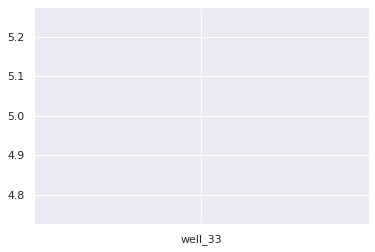

In [186]:
plt.plot(testing_well_tt_temp2['hv'])

In [421]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [422]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))
y_test_scaled = y_scaler.transform(y_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=y_test.columns)

In [369]:
y_train_scaled.shape

(2859, 3)

In [423]:
X_test_2_scaled = X_scaler.transform(X_test_2)
X_test_2_scaled = pd.DataFrame(X_test_2_scaled, index=X_test_2.index, columns=X_test_2.columns)

In [424]:
# %%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 5
model_store = []

# We store our training performance in 'history_store'
history_store = []

#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(32, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform'))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=5000, validation_split=0.5,
                                   shuffle=True, batch_size=256, callbacks=callbacks,
                                   verbose=0))
    model_store.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

-------------------------------------------------- Completed Training of Model # 0
-------------------------------------------------- Total Epochs Range: range(0, 1304)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 1
-------------------------------------------------- Total Epochs Range: range(0, 937)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 2
-------------------------------------------------- Total Epochs Range: range(0, 962)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 3
-------------------------------------------------- Total Epochs Range: range(0, 1352)
--------------------------------------------------------------------------

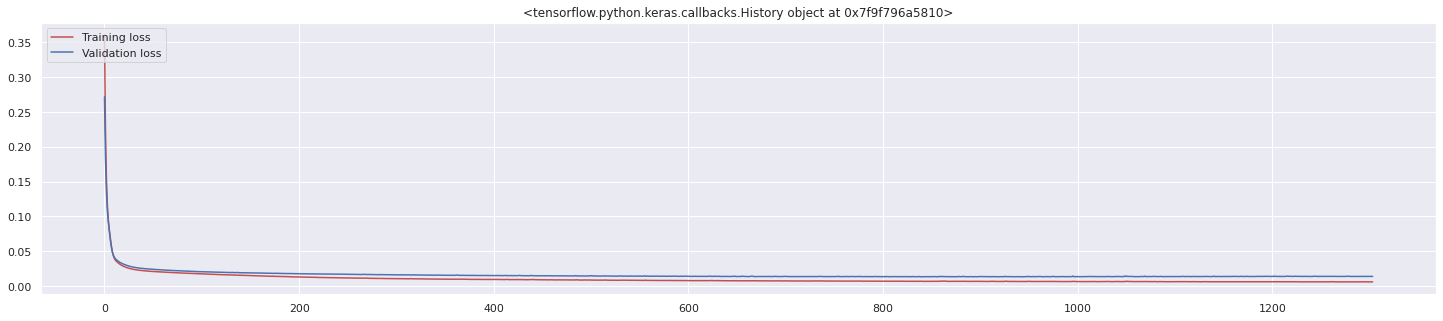

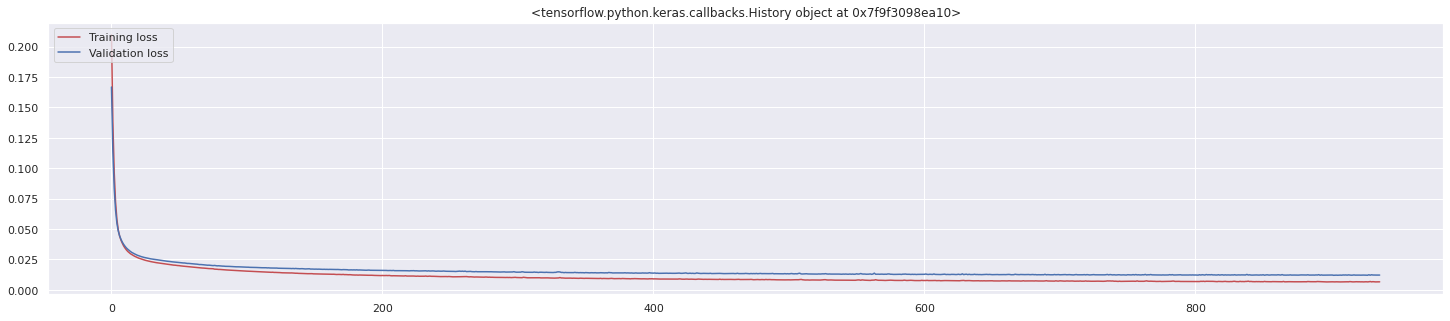

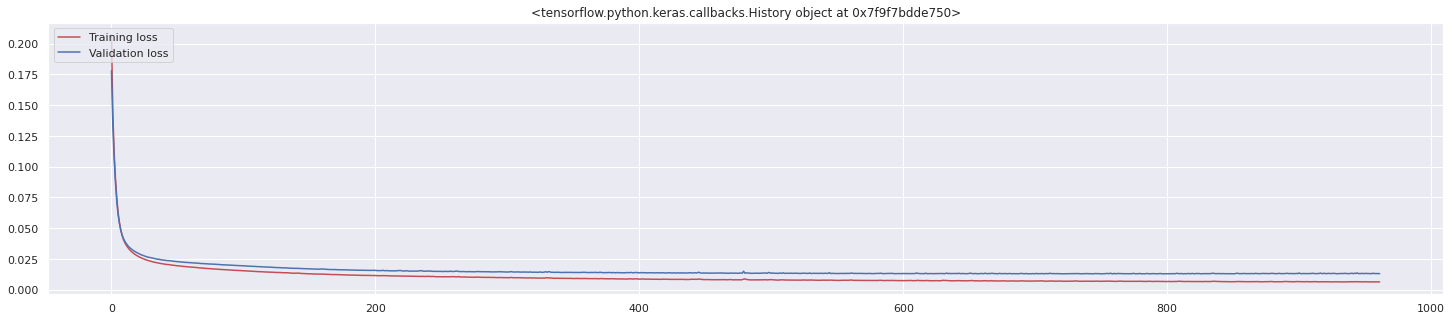

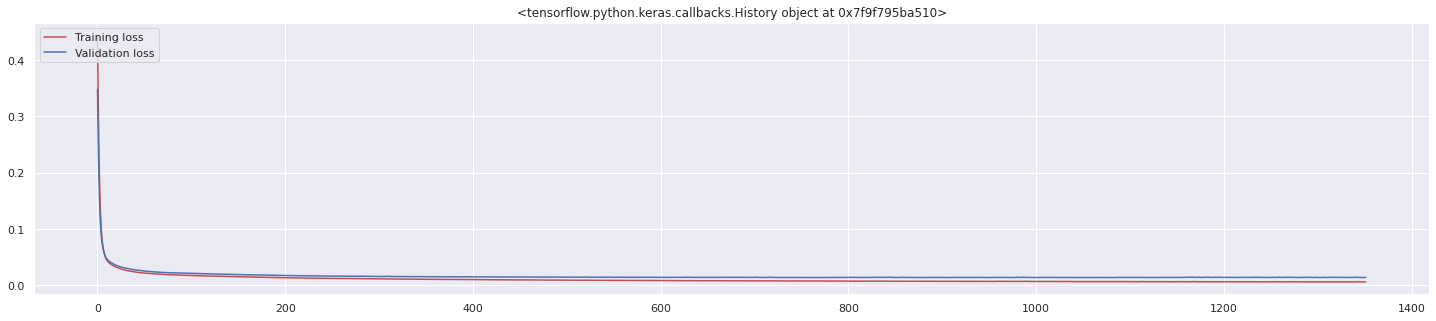

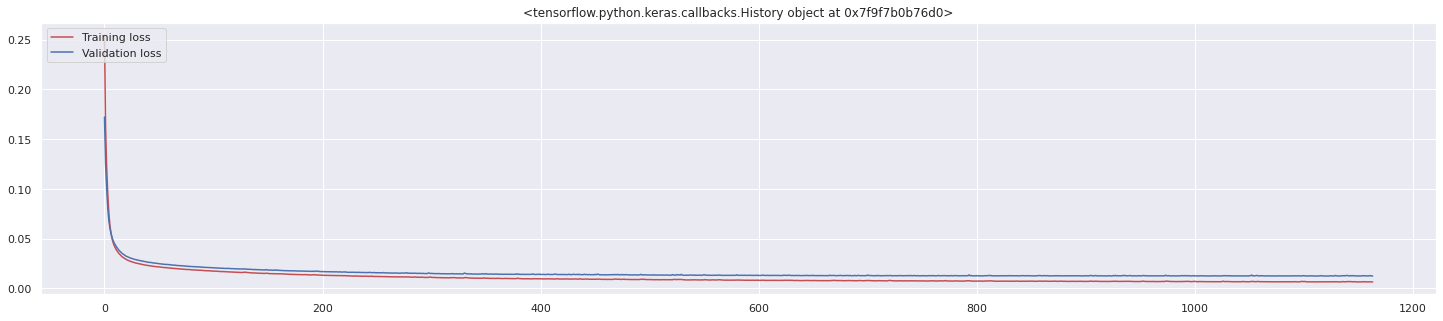

In [425]:
for history in history_store:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(25,5))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend(loc='upper left')
    plt.title(str(history))

In [426]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)
Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)
y_test = testing_well_tt_temp[targets]
Results = y_test.copy()
Results['Zp_Prediction'] = Zp_ensemble
Results['Zs_Prediction'] = Zs_ensemble
Results['Rhob_Prediction'] = Rhob_ensemble
Results['twt'] = X_test['twt']
Results = Results.reset_index()
Results

,well_name,Zp,Zs,rhob,Zp_Prediction,Zs_Prediction,Rhob_Prediction,twt
0,well_33,30170.712683,18177.815140,2.2705,29534.656250,16177.640625,2.534418,3038.0
1,well_33,29173.007638,16367.512751,2.2486,29416.050781,16119.744141,2.534334,3038.5
2,well_33,29640.355087,17413.894150,2.2047,29252.474609,16036.537109,2.534116,3039.0
3,well_33,30388.937556,16143.283957,2.2618,28650.255859,15717.759766,2.533549,3040.5
4,well_33,28611.563104,16002.872511,2.2507,28430.093750,15569.440430,2.535141,3041.0
...,...,...,...,...,...,...,...,...
459,well_33,35670.487327,24008.216842,2.4520,36470.511719,22235.248047,2.440462,3275.0
460,well_33,38100.632885,24697.457586,2.5694,36460.316406,22257.468750,2.440044,3275.5
461,well_33,35727.080956,23617.950301,2.5828,36436.312500,22289.558594,2.438280,3276.0
462,well_33,35371.186020,23286.449833,2.4341,36443.585938,22362.847656,2.435921,3276.5


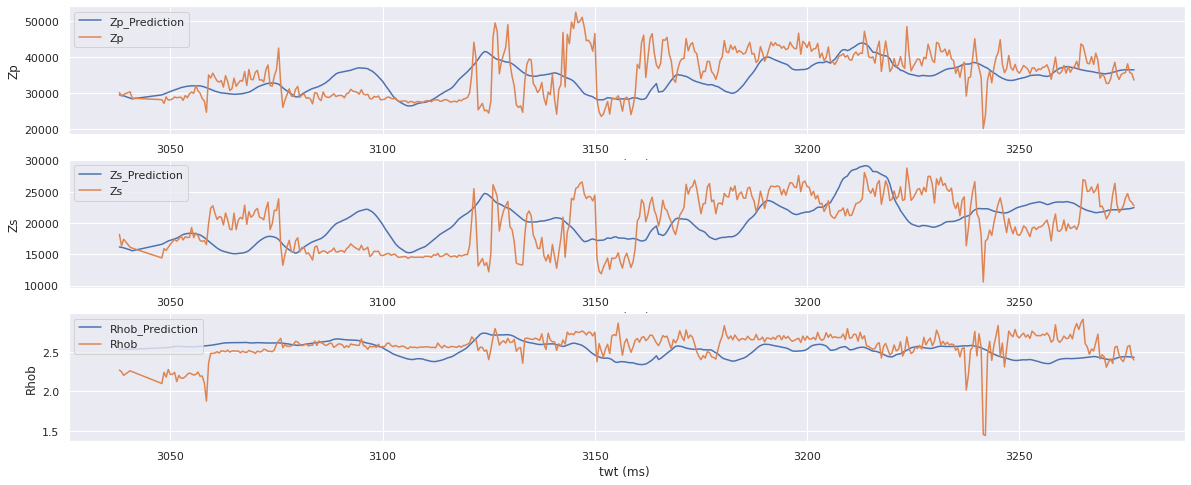

In [427]:
# checking well_33 prediction result with true value
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results['twt'],Results[['Zp_Prediction','Zp']])
plt.legend(loc='upper left', labels =['Zp_Prediction','Zp'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results['twt'],Results[['Zs_Prediction','Zs']])
plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob']])
plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

In [428]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_2_scaled)) for model in model_store]
yhats = np.array(yhats)
Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)
y_test = test_testing_well_tt[targets]
Results = y_test.copy()
Results['Zp'] = Zp_ensemble
Results['Zs'] = Zs_ensemble
Results['rhob'] = Rhob_ensemble
Results['twt'] = X_test_2['twt']
Results = Results.reset_index()
Results

,level_0,well_name,Zp,Zs,rhob,twt
0,well_07,well_07,23509.332031,11611.797852,2.378378,2700.0
1,well_07,well_07,23160.427734,11330.205078,2.392468,2700.5
2,well_07,well_07,23333.574219,11469.513672,2.409361,2701.0
3,well_07,well_07,23467.615234,11570.901367,2.423118,2701.5
4,well_07,well_07,23677.064453,11713.274414,2.437258,2702.0
...,...,...,...,...,...,...
1768,well_13,well_13,36472.300781,19850.425781,2.522084,3383.5
1769,well_13,well_13,36324.195312,19615.308594,2.531138,3384.0
1770,well_13,well_13,36156.832031,19383.455078,2.539793,3384.5
1771,well_13,well_13,36146.292969,19320.509766,2.546347,3385.0


In [429]:
result2 = Results.set_index(['well_name','twt'])

In [430]:
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_testing_wells_blank.json.gz'

well_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)

well_df

inline      xline  rhob  p_impedance  s_impedance
well_id twt                                                         
well_07 2700.0  3256.5233  1389.3571   NaN          NaN          NaN
        2700.5  3256.5234  1389.3559   NaN          NaN          NaN
        2701.0  3256.5236  1389.3547   NaN          NaN          NaN
        2701.5  3256.5237  1389.3535   NaN          NaN          NaN
        2702.0  3256.5238  1389.3523   NaN          NaN          NaN
...                   ...        ...   ...          ...          ...
well_13 3383.5  2407.1952  2675.8771   NaN          NaN          NaN
        3384.0  2407.1905  2675.8925   NaN          NaN          NaN
        3384.5  2407.1858  2675.9078   NaN          NaN          NaN
        3385.0  2407.1811  2675.9232   NaN          NaN          NaN
        3385.5  2407.1763  2675.9386   NaN          NaN          NaN

[1773 rows x 5 columns]

In [431]:
well_df[['rhob','p_impedance','s_impedance']] = result2[['rhob','Zp','Zs']]

In [432]:
well_df.describe()

,inline,xline,rhob,p_impedance,s_impedance
count,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000
mean,3007.407384,1766.345919,2.551939,33103.222656,18312.083984
std,386.799776,584.865566,0.098417,6948.302734,4804.417969
min,2407.176300,1389.007600,2.220929,22911.646484,10852.541016
25%,2408.257100,1389.061300,2.475074,27220.019531,14435.789062
50%,3256.584400,1389.211300,2.537608,31961.046875,17754.140625
75%,3257.002100,2671.080300,2.633312,38501.964844,22047.964844
max,3257.313500,2675.938600,2.883746,52293.195312,30413.792969


In [433]:
well_df2 = well_df.copy()

In [434]:
bucket = 's3://sagemaker-gitc2021/poseidon/wells/intermediate/'

file_name = 'NeverStop_Intermediate05_Results_20210425.json.gz'
# file_name = 'NeverStop_Intermediate_Results_20210425.json'

well_df.reset_index(inplace=True)
well_df.to_json(
#     path_or_buf=bucket + file_name,
    path_or_buf=file_name,
    double_precision=4,
    compression='gzip'
)

In [91]:
!pip show pandas

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/site-packages
Requires: pytz, python-dateutil, numpy
Required-by: smclarify, seaborn, sagemaker, sagemaker-tensorflow-training
